In [17]:
import numpy as np
import qnmfits.qnm as qnm

import matplotlib.pyplot as plt
import matplotlib.colors
import rcparams
plt.rcParams.update(rcparams.params)

from scipy.optimize import minimize

from cmcrameri import cm

import astropy.constants as const
G, c, M_sun = const.G.value, const.c.value, const.M_sun.value

rng = np.random.default_rng()

# G/c**3 (s/kg)
conversion = G/c**3

In [2]:
def fun(chi, Q_star, l, m, n):
    """
    Calculates the absolute difference between a quality factor given by a 
    particular spin, and a target quality factor. This is used with scipy
    minimize to convert a frequency and damping time measurement to a spin.
    """
    
    omega = qnm.omega(l, m, n, 1, chi)
    f = np.real(omega)/(2*np.pi)
    tau = -1/np.imag(omega)
    Q = np.pi*f*tau
    
    return abs(Q_star - Q)

In [ ]:
# Base plot
# ---------

fig, ax = plt.subplots(figsize=(6,4), dpi=180)

chi_array = np.linspace(0, 0.99, 200)

for n in range(2):
    for l in range(2,4):
        
        if (l==3) & (n==1):
            pass
        
        else:
            for m in range(-l,l+1):
                
                # Evaluate the QNM frequencies
                frequencies = qnm.omega(l, m, n, 1, chi_array)
                        
                # Add to the figure
                ax.plot(
                    np.real(frequencies)/(2*np.pi), 
                    -np.imag(frequencies), 
                    c='C0'
                )

ax.set_xlabel('$M_ff_{\ell m n}$')
ax.set_ylabel('$M_f/ \\tau_{\ell m n}$')

ax.set_xlim(0)
ax.set_ylim(0)

# Add measurements
# ----------------

# The measured frequency and damping time
f_star = 200
tau_star = 0.007

# The quality factor
Q_star = np.pi*f_star*tau_star

# Add the line corresponding to the measurement
x = np.linspace(0, 1)
ax.plot(x, (np.pi/Q_star)*x, c='k')

# Identify points of intersection between the measurement and the Kerr 
# spectrum

intersected_modes = []
fitted_spins = []
fitted_masses = []

for n in range(2):
    for l in range(2,4):
        
        if (l==3) & (n==1):
            pass
        
        else:
            for m in range(-l,l+1):
                result = minimize(
                    fun, 
                    x0=0.5, 
                    args=(Q_star, l, m, n), 
                    bounds=[(0.,0.99)]
                )
                if result['fun']<1e-5:
                    
                    chi_fit = result['x'][0]
                    omega_fit = qnm.omega(l, m, n, 1, chi_fit)
                    
                    Mf_fit = (np.real(omega_fit)/(2*np.pi))/(f_star*conversion)
                    
                    intersected_modes.append((l,m,n))
                    fitted_spins.append(chi_fit)
                    fitted_masses.append(Mf_fit)
                    
                    ax.plot(
                        np.real(omega_fit)/(2*np.pi), 
                        -np.imag(omega_fit), 
                        'o', 
                        c='C3',
                        alpha=0.5
                    )
                    
print('Measurement compatible with modes:')
for mode, chi, Mf in zip(intersected_modes, fitted_spins, fitted_masses):
    print(f'{mode}, chi = {chi:.3f}, Mf = {Mf/M_sun:.3f} solar masses')

In [ ]:
def bh_spectroscopy(f_star, tau_star, plot=True, verbose=True):
    
    # The quality factor
    Q_star = np.pi*f_star*tau_star
    
    if plot:
        
        # Base plot
        # ---------

        fig, ax = plt.subplots(figsize=(6,4)) # , dpi=180)

        chi_array = np.linspace(0, 0.99, 200)

        for n in range(2):
            for l in range(2,4):

                if (l==3) & (n==1):
                    pass

                else:
                    for m in range(-l,l+1):

                        # Evaluate the QNM frequencies
                        frequencies = qnm.omega(l, m, n, 1, chi_array)

                        # Add to the figure
                        ax.plot(
                            np.real(frequencies)/(2*np.pi), 
                            -np.imag(frequencies), 
                            c='C0'
                        )

        ax.set_xlabel('$M_ff_{\ell m n}$')
        ax.set_ylabel('$M_f/ \\tau_{\ell m n}$')

        ax.set_xlim(0)
        ax.set_ylim(0)

        # Add measurements
        # ----------------

        # Add the line corresponding to the measurement
        x = np.linspace(0, 1)
        ax.plot(x, (np.pi/Q_star)*x, c='k')

    # Identify points of intersection between the measurement and the Kerr 
    # spectrum

    intersected_modes = []
    fitted_spins = []
    fitted_masses = []

    for n in range(2):
        for l in range(2,4):

            if (l==3) & (n==1):
                pass

            else:
                for m in range(-l,l+1):
                    result = minimize(
                        fun, 
                        x0=0.5, 
                        args=(Q_star, l, m, n), 
                        bounds=[(0.,0.99)]
                    )
                    if result['fun']<1e-5:

                        chi_fit = result['x'][0]
                        omega_fit = qnm.omega(l, m, n, 1, chi_fit)

                        Mf_fit = (np.real(omega_fit)/(2*np.pi))/(f_star*conversion)

                        intersected_modes.append((l,m,n))
                        fitted_spins.append(chi_fit)
                        fitted_masses.append(Mf_fit)
                        
                        if plot:
                            ax.plot(
                                np.real(omega_fit)/(2*np.pi), 
                                -np.imag(omega_fit), 
                                'o', 
                                c='C3',
                                alpha=0.5
                            )
    
    if verbose:
        print('Measurement compatible with modes:')
        for mode, chi, Mf in zip(intersected_modes, fitted_spins, fitted_masses):
            print(f'{mode}, chi = {chi:.3f}, Mf = {Mf/M_sun:.3f} solar masses')
        
    for mode, chi, Mf in zip(intersected_modes, fitted_spins, fitted_masses):
        if mode == (2,2,1):
            return (chi, Mf/M_sun)

In [ ]:
_ = bh_spectroscopy(f_star = 200, tau_star = 0.007)

In [ ]:
_ = bh_spectroscopy(f_star = 2.00000000e+02, tau_star = 2.33333333e-03)

In [ ]:
bh_spectroscopy(f_star = 300, tau_star = 0.001, plot=False)

In [ ]:
f_array = np.linspace(200, 300, 10)
tau_array = np.linspace(0.001, 0.005, 10)

chi_target = 0.853
Mf_target = 100.429 

results = []

for f_star in f_array:
    for tau_star in tau_array:
        chi_Mf = bh_spectroscopy(f_star, tau_star, plot=False, verbose=False)
        if chi_Mf is not None:
            chi = chi_Mf[0]
            Mf = chi_Mf[1]
            diff = (chi-chi_target)**2 + ((Mf-Mf_target)/Mf)**2
            results.append((f_star, tau_star, diff))

In [ ]:
results = np.array(results)
results[np.argmin(results[:,-1])]

In [ ]:
# Base plot
# ---------

fig, axs = plt.subplots(1, 2, figsize=(7.5,4), dpi=180)

axs[0].set_box_aspect(1)
axs[1].set_box_aspect(1)

chi_array = np.linspace(0, 0.99, 200)
cmap = cm.batlow

for n in range(2):
    for l in range(2,4):
        for m in range(-l,l+1):
            
            if l == m:

                # Evaluate the QNM frequencies
                frequencies = qnm.omega(l, m, n, 1, chi_array)

                # Add to the figure
                axs[0].plot(
                    np.real(frequencies)/(2*np.pi), 
                    -np.imag(frequencies), 
                    c='C0'
                )

axs[0].set_xlabel('$M_ff_{\ell m n}$')
axs[0].set_ylabel('$M_f/ \\tau_{\ell m n}$')

axs[1].set_xlabel('$M_f\,[M_\odot]$')
axs[1].set_ylabel('$\chi_f$')

axs[0].set_xlim(0)
axs[0].set_ylim(0)

axs[1].set_ylim(0,1)

# Add measurements
# ----------------

Mf_star, chif_star = 68.779, 0.69

modes = [(2,2,0), (2,2,1), (3,3,0)]
colours = ['C3', 'C0', 'C7']
markers_l = ['s', 'X', 'o']
markers_r = ['s', 'x', 'o']
markersizes = [9, 6, 8]

for i, (l, m, n) in enumerate(modes):
    
    omega_star = qnm.omega(l, m, n, 1, chif_star, M_sun*Mf_star*conversion)
    f_star = np.real(omega_star)/(2*np.pi)
    tau_star = -1/np.imag(omega_star)

    # The quality factor
    Q_star = np.pi*f_star*tau_star

    # Add the line corresponding to the measurement
    x = np.linspace(0, 1)
    axs[0].plot(x, (np.pi/Q_star)*x, c='k', lw=1, alpha=0.85)

    # Identify points of intersection between the measurement and the Kerr 
    # spectrum

    intersected_modes = []
    fitted_spins = []
    fitted_masses = []
    
    j = 1
    
    for n in range(2):
        for l in range(2,4):
            for m in range(-l,l+1):

                if l == m:
                    result = minimize(
                        fun, 
                        x0=0.5, 
                        args=(Q_star, l, m, n), 
                        bounds=[(0.,0.99)]
                    )
                    if result['fun']<1e-5:

                        chi_fit = result['x'][0]
                        omega_fit = qnm.omega(l, m, n, 1, chi_fit)

                        Mf_fit = (np.real(omega_fit)/(2*np.pi))/(f_star*conversion)

                        intersected_modes.append((l,m,n))
                        fitted_spins.append(chi_fit)
                        fitted_masses.append(Mf_fit)
                        
                        if abs(Mf_fit/M_sun-Mf_star) < 1: 

                            axs[0].plot(
                                np.real(omega_fit)/(2*np.pi), 
                                -np.imag(omega_fit), 
                                markers_l[i], 
                                # c=cmap(j/6),
                                c=f'C{j}',
                                markeredgecolor='k',
                                markeredgewidth=1.2,
                                # alpha=0.75
                            )
                        
                        else:
                            axs[0].plot(
                                np.real(omega_fit)/(2*np.pi), 
                                -np.imag(omega_fit), 
                                markers_l[i], 
                                # c=cmap(j/6),
                                c=f'C{j}',
                                # alpha=0.75
                            )

                        axs[1].plot(
                            Mf_fit/M_sun,
                            chi_fit,
                            markers_r[i],
                            ms=markersizes[i],
                            # c=cmap(j/6),
                            c=f'C{j}',
                            fillstyle='none',
                            # zorder=10-j
                        )
                    
                    j += 1

    print('Measurement compatible with modes:')
    for mode, chi, Mf in zip(intersected_modes, fitted_spins, fitted_masses):
        print(f'{mode}, chi = {chi:.3f}, Mf = {Mf/M_sun:.3f} solar masses')

axs[1].axhline(chif_star, c='k', alpha=0.5, zorder=-10, lw=0.75) 
axs[1].axvline(Mf_star, c='k', alpha=0.5, zorder=-10, lw=0.75) 

fig.savefig('bh_spectroscopy.pdf', bbox_inches='tight')

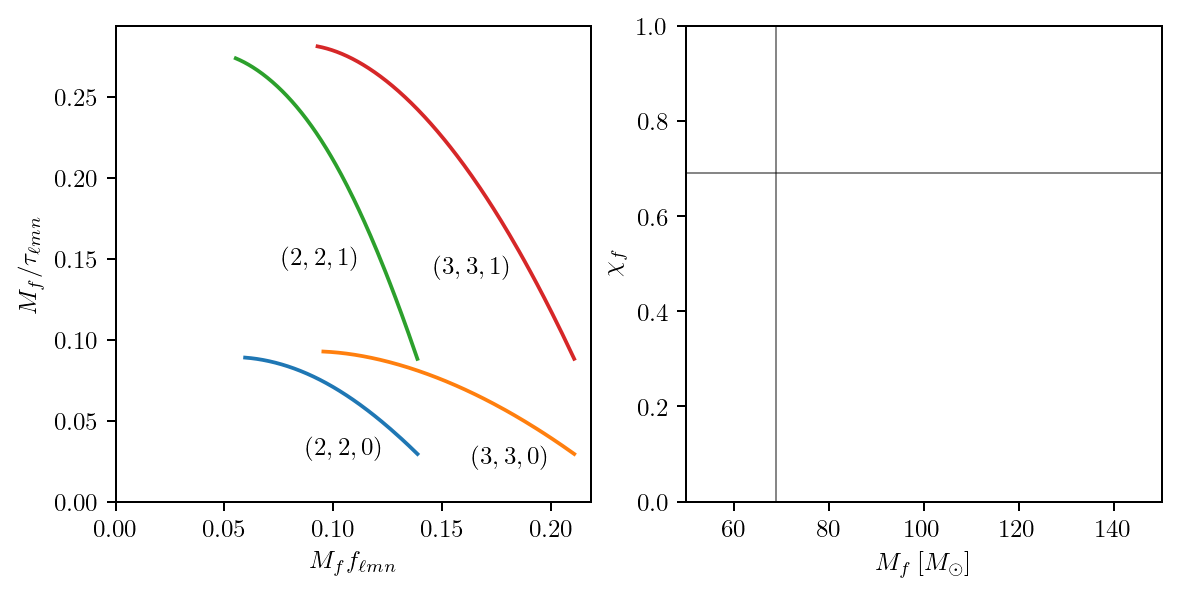

In [102]:
# Base plot
# ---------

fig, axs = plt.subplots(1, 2, figsize=(7.5,4), dpi=180)

axs[0].set_box_aspect(1)
axs[1].set_box_aspect(1)

chi_array = np.linspace(0, 0.99, 200)
cmap = cm.batlow

j = 0

for n in range(2):
    for l in range(2,4):
        for m in range(-l,l+1):
            
            if l == m:

                # Evaluate the QNM frequencies
                frequencies = qnm.omega(l, m, n, 1, chi_array)

                # Add to the figure
                axs[0].plot(
                    np.real(frequencies)/(2*np.pi), 
                    -np.imag(frequencies), 
                    c=f'C{j}'
                )
            
                j += 1

axs[0].set_xlabel('$M_ff_{\ell m n}$')
axs[0].set_ylabel('$M_f/ \\tau_{\ell m n}$')

axs[1].set_xlabel('$M_f\,[M_\odot]$')
axs[1].set_ylabel('$\chi_f$')

axs[0].set_xlim(0)
axs[0].set_ylim(0)

axs[1].set_ylim(0,1)

# Add measurements
# ----------------

Mf_star, chif_star = 68.779, 0.69

modes = [(2,2,0), (2,2,1), (3,3,0)]
colours = ['C3', 'C0', 'C7']
markers_l = ['s', 'X', 'o']
markers_r = ['s', 'x', 'o']
markersizes = [9, 6, 8]

for i, (l, m, n) in enumerate(modes):
    
    omega_star = qnm.omega(l, m, n, 1, chif_star, M_sun*Mf_star*conversion)
    f_star = np.real(omega_star)/(2*np.pi)
    tau_star = -1/np.imag(omega_star)

    # The quality factor
    Q_star = np.pi*f_star*tau_star

    # Add the line corresponding to the measurement
    x = np.linspace(0, 1)
    axs[0].plot(x, (np.pi/Q_star)*x, c='k', alpha=0.5, lw=1)

    # Identify points of intersection between the measurement and the Kerr 
    # spectrum

    intersected_modes = []
    fitted_spins = []
    fitted_masses = []
    
    j = 0
    
    for n in range(2):
        for l in range(2,4):
            for m in range(-l,l+1):

                if l == m:
                    result = minimize(
                        fun, 
                        x0=0.5, 
                        args=(Q_star, l, m, n), 
                        bounds=[(0.,0.99)]
                    )
                    if result['fun']<1e-5:

                        chi_fit = result['x'][0]
                        omega_fit = qnm.omega(l, m, n, 1, chi_fit)

                        Mf_fit = (np.real(omega_fit)/(2*np.pi))/(f_star*conversion)

                        intersected_modes.append((l,m,n))
                        fitted_spins.append(chi_fit)
                        fitted_masses.append(Mf_fit)
                        
                        if abs(Mf_fit/M_sun-Mf_star) < 1: 

                            axs[0].plot(
                                np.real(omega_fit)/(2*np.pi), 
                                -np.imag(omega_fit), 
                                markers_l[i], 
                                # c=cmap(j/6),
                                c=f'C{j}',
                                markeredgecolor='k',
                                markeredgewidth=0.75,
                                # alpha=0.75
                            )
                        
                        else:
                            axs[0].plot(
                                np.real(omega_fit)/(2*np.pi), 
                                -np.imag(omega_fit), 
                                markers_l[i], 
                                # c=cmap(j/6),
                                c=f'C{j}',
                                # alpha=0.75
                            )

                        axs[1].plot(
                            Mf_fit/M_sun,
                            chi_fit,
                            markers_r[i],
                            ms=markersizes[i],
                            # c=cmap(j/6),
                            c=f'C{j}',
                            fillstyle='none',
                            zorder=10-j
                        )
                    
                    j += 1

#     print('Measurement compatible with modes:')
#     for mode, chi, Mf in zip(intersected_modes, fitted_spins, fitted_masses):
#         print(f'{mode}, chi = {chi:.3f}, Mf = {Mf/M_sun:.3f} solar masses')

axs[1].axhline(chif_star, c='k', alpha=0.5, zorder=-10, lw=0.75) 
axs[1].axvline(Mf_star, c='k', alpha=0.5, zorder=-10, lw=0.75) 

axs[1].set_xlim((49.963399559552876, 150.0266340693438))

axs[0].text(0.4, 0.1, '$(2,2,0)$', transform=axs[0].transAxes)  
axs[0].text(0.75, 0.08, '$(3,3,0)$', transform=axs[0].transAxes)  
axs[0].text(0.35, 0.5, '$(2,2,1)$', transform=axs[0].transAxes) 
axs[0].text(0.67, 0.48, '$(3,3,1)$', transform=axs[0].transAxes) 

# fig.savefig('bh_spectroscopy_alt.pdf', bbox_inches='tight')

fig.savefig('out/0.png', bbox_inches='tight', dpi=360)

In [112]:
# Base plot
# ---------

# Add measurements
# ----------------

Mf_star, chif_star = 68.779, 0.69

modes = [(2,2,0), (2,2,1)] # , (3,3,0)]
colours = ['C3', 'C0', 'C7']
markers_l = ['s', 'X', 'o']
markers_r = ['s', 'x', 'o']
markersizes = [9, 6, 8]


for i, (l, m, n) in enumerate(modes):
    
    omega_star = qnm.omega(l, m, n, 1, chif_star, M_sun*Mf_star*conversion)
    f_star = np.real(omega_star)/(2*np.pi)
    tau_star = -1/np.imag(omega_star)

    # The quality factor
    Q_star = np.pi*f_star*tau_star
    
    for jj, x_upper in enumerate(np.linspace(0,0.25,100)):
        
        fig, axs = plt.subplots(1, 2, figsize=(7.5,4), dpi=180)

        axs[0].set_box_aspect(1)
        axs[1].set_box_aspect(1)

        chi_array = np.linspace(0, 0.99, 200)
        cmap = cm.batlow

        j = 0

        for n in range(2):
            for l in range(2,4):
                for m in range(-l,l+1):

                    if l == m:

                        # Evaluate the QNM frequencies
                        frequencies = qnm.omega(l, m, n, 1, chi_array)

                        # Add to the figure
                        axs[0].plot(
                            np.real(frequencies)/(2*np.pi), 
                            -np.imag(frequencies), 
                            c=f'C{j}'
                        )

                        j += 1

        axs[0].set_xlabel('$M_ff_{\ell m n}$')
        axs[0].set_ylabel('$M_f/ \\tau_{\ell m n}$')

        axs[1].set_xlabel('$M_f\,[M_\odot]$')
        axs[1].set_ylabel('$\chi_f$')

        axs[0].set_xlim(0)
        axs[0].set_ylim(0)

        axs[1].set_ylim(0,1)


        # Add the line corresponding to the measurement
        x = np.linspace(0, x_upper)
        axs[0].plot(x, (np.pi/Q_star)*x, c='k', alpha=0.5, lw=1)

        # Identify points of intersection between the measurement and the Kerr 
        # spectrum

        intersected_modes = []
        fitted_spins = []
        fitted_masses = []

        j = 0

        for n in range(2):
            for l in range(2,4):
                for m in range(-l,l+1):

                    if l == m:
                        result = minimize(
                            fun, 
                            x0=0.5, 
                            args=(Q_star, l, m, n), 
                            bounds=[(0.,0.99)]
                        )
                        if result['fun']<1e-5:

                            chi_fit = result['x'][0]
                            omega_fit = qnm.omega(l, m, n, 1, chi_fit)

                            Mf_fit = (np.real(omega_fit)/(2*np.pi))/(f_star*conversion)
                            
                            if x_upper >= np.real(omega_fit)/(2*np.pi):

                                intersected_modes.append((l,m,n))
                                fitted_spins.append(chi_fit)
                                fitted_masses.append(Mf_fit)

                                if abs(Mf_fit/M_sun-Mf_star) < 1: 

                                    axs[0].plot(
                                        np.real(omega_fit)/(2*np.pi), 
                                        -np.imag(omega_fit), 
                                        markers_l[i], 
                                        # c=cmap(j/6),
                                        c=f'C{j}',
                                        markeredgecolor='k',
                                        markeredgewidth=0.75,
                                        # alpha=0.75
                                    )

                                else:
                                    axs[0].plot(
                                        np.real(omega_fit)/(2*np.pi), 
                                        -np.imag(omega_fit), 
                                        markers_l[i], 
                                        # c=cmap(j/6),
                                        c=f'C{j}',
                                        # alpha=0.75
                                    )

                                axs[1].plot(
                                    Mf_fit/M_sun,
                                    chi_fit,
                                    markers_r[i],
                                    ms=markersizes[i],
                                    # c=cmap(j/6),
                                    c=f'C{j}',
                                    fillstyle='none',
                                    zorder=10-j
                                )

                        j += 1

#         print('Measurement compatible with modes:')
#         for mode, chi, Mf in zip(intersected_modes, fitted_spins, fitted_masses):
#             print(f'{mode}, chi = {chi:.3f}, Mf = {Mf/M_sun:.3f} solar masses')

        axs[1].axhline(chif_star, c='k', alpha=0.5, zorder=-10, lw=0.75) 
        axs[1].axvline(Mf_star, c='k', alpha=0.5, zorder=-10, lw=0.75) 

        axs[1].set_xlim((49.963399559552876, 150.0266340693438))

        # fig.savefig('bh_spectroscopy_alt.pdf', bbox_inches='tight')

        fig.savefig(f'out/{jj}.png', bbox_inches='tight', dpi=360)
        plt.close()

In [118]:
Mf_star, chif_star = 68.779, 0.69

modes = [(2,2,0), (2,2,1)]
animated_mode = (3,3,0)

colours = ['C3', 'C0', 'C7']
markers_l = ['s', 'X', 'o']
markers_r = ['s', 'x', 'o']
markersizes = [9, 6, 8]

for jj, x_upper in enumerate(np.linspace(0,0.25,100)):

    fig, axs = plt.subplots(1, 2, figsize=(7.5,4), dpi=180)

    axs[0].set_box_aspect(1)
    axs[1].set_box_aspect(1)

    chi_array = np.linspace(0, 0.99, 200)

    j = 0

    for n in range(2):
        for l in range(2,4):
            for m in range(-l,l+1):

                if l == m:

                    # Evaluate the QNM frequencies
                    frequencies = qnm.omega(l, m, n, 1, chi_array)

                    # Add to the figure
                    axs[0].plot(
                        np.real(frequencies)/(2*np.pi), 
                        -np.imag(frequencies), 
                        c=f'C{j}'
                    )

                    j += 1

    axs[0].set_xlabel('$M_ff_{\ell m n}$')
    axs[0].set_ylabel('$M_f/ \\tau_{\ell m n}$')

    axs[1].set_xlabel('$M_f\,[M_\odot]$')
    axs[1].set_ylabel('$\chi_f$')

    axs[0].set_xlim(0)
    axs[0].set_ylim(0)
    
    axs[1].set_xlim((49.963399559552876, 150.0266340693438))
    axs[1].set_ylim(0,1)

    for i, (l, m, n) in enumerate(modes):

        omega_star = qnm.omega(l, m, n, 1, chif_star, M_sun*Mf_star*conversion)
        f_star = np.real(omega_star)/(2*np.pi)
        tau_star = -1/np.imag(omega_star)

        # The quality factor
        Q_star = np.pi*f_star*tau_star

        # Add the line corresponding to the measurement
        x = np.linspace(0, 1)
        axs[0].plot(x, (np.pi/Q_star)*x, c='k', alpha=0.5, lw=1)

        # Identify points of intersection between the measurement and the Kerr 
        # spectrum

        intersected_modes = []
        fitted_spins = []
        fitted_masses = []

        j = 0

        for n in range(2):
            for l in range(2,4):
                for m in range(-l,l+1):

                    if l == m:
                        result = minimize(
                            fun, 
                            x0=0.5, 
                            args=(Q_star, l, m, n), 
                            bounds=[(0.,0.99)]
                        )
                        if result['fun']<1e-5:

                            chi_fit = result['x'][0]
                            omega_fit = qnm.omega(l, m, n, 1, chi_fit)

                            Mf_fit = (np.real(omega_fit)/(2*np.pi))/(f_star*conversion)

                            intersected_modes.append((l,m,n))
                            fitted_spins.append(chi_fit)
                            fitted_masses.append(Mf_fit)

                            if abs(Mf_fit/M_sun-Mf_star) < 1: 

                                axs[0].plot(
                                    np.real(omega_fit)/(2*np.pi), 
                                    -np.imag(omega_fit), 
                                    markers_l[i], 
                                    # c=cmap(j/6),
                                    c=f'C{j}',
                                    markeredgecolor='k',
                                    markeredgewidth=0.75,
                                    # alpha=0.75
                                )

                            else:
                                axs[0].plot(
                                    np.real(omega_fit)/(2*np.pi), 
                                    -np.imag(omega_fit), 
                                    markers_l[i], 
                                    # c=cmap(j/6),
                                    c=f'C{j}',
                                    # alpha=0.75
                                )

                            axs[1].plot(
                                Mf_fit/M_sun,
                                chi_fit,
                                markers_r[i],
                                ms=markersizes[i],
                                # c=cmap(j/6),
                                c=f'C{j}',
                                fillstyle='none',
                                zorder=10-j
                            )

                        j += 1
    
    l, m, n = animated_mode
    i += 1
    
    omega_star = qnm.omega(l, m, n, 1, chif_star, M_sun*Mf_star*conversion)
    f_star = np.real(omega_star)/(2*np.pi)
    tau_star = -1/np.imag(omega_star)

    # The quality factor
    Q_star = np.pi*f_star*tau_star

    # Add the line corresponding to the measurement
    x = np.linspace(0, x_upper)
    axs[0].plot(x, (np.pi/Q_star)*x, c='k', alpha=0.5, lw=1)

    # Identify points of intersection between the measurement and the Kerr 
    # spectrum

    intersected_modes = []
    fitted_spins = []
    fitted_masses = []

    j = 0

    for n in range(2):
        for l in range(2,4):
            for m in range(-l,l+1):

                if l == m:
                    result = minimize(
                        fun, 
                        x0=0.5, 
                        args=(Q_star, l, m, n), 
                        bounds=[(0.,0.99)]
                    )
                    if result['fun']<1e-5:

                        chi_fit = result['x'][0]
                        omega_fit = qnm.omega(l, m, n, 1, chi_fit)

                        Mf_fit = (np.real(omega_fit)/(2*np.pi))/(f_star*conversion)

                        if x_upper >= np.real(omega_fit)/(2*np.pi):

                            intersected_modes.append((l,m,n))
                            fitted_spins.append(chi_fit)
                            fitted_masses.append(Mf_fit)

                            if abs(Mf_fit/M_sun-Mf_star) < 1: 

                                axs[0].plot(
                                    np.real(omega_fit)/(2*np.pi), 
                                    -np.imag(omega_fit), 
                                    markers_l[i], 
                                    # c=cmap(j/6),
                                    c=f'C{j}',
                                    markeredgecolor='k',
                                    markeredgewidth=0.75,
                                    # alpha=0.75
                                )

                            else:
                                axs[0].plot(
                                    np.real(omega_fit)/(2*np.pi), 
                                    -np.imag(omega_fit), 
                                    markers_l[i], 
                                    # c=cmap(j/6),
                                    c=f'C{j}',
                                    # alpha=0.75
                                )

                            axs[1].plot(
                                Mf_fit/M_sun,
                                chi_fit,
                                markers_r[i],
                                ms=markersizes[i],
                                # c=cmap(j/6),
                                c=f'C{j}',
                                fillstyle='none',
                                zorder=10-j
                            )

                    j += 1

    axs[1].axhline(chif_star, c='k', alpha=0.5, zorder=-10, lw=0.75) 
    axs[1].axvline(Mf_star, c='k', alpha=0.5, zorder=-10, lw=0.75) 

    fig.savefig(f'out/{jj}.png', bbox_inches='tight', dpi=360)
    plt.close()

In [57]:
# Base plot
# ---------

# Add measurements
# ----------------

Mf_star, chif_star = 68.779, 0.69

modes = [(2,2,0)]
colours = ['C3', 'C0', 'C7']
markers_l = ['s', 'X', 'o']
markers_r = ['s', 'x', 'o']
markersizes = [6, 6, 8]

omega_star = qnm.omega(2, 2, 0, 1, chif_star, M_sun*Mf_star*conversion)
f_star = np.real(omega_star)/(2*np.pi)
tau_star = -1/np.imag(omega_star)

vals = rng.multivariate_normal(
    mean=np.array([f_star, tau_star]), 
    cov=np.array([[10**2,0],[0,0.001**2]]), 
    size=750
    )

fixed_vals = vals.copy()

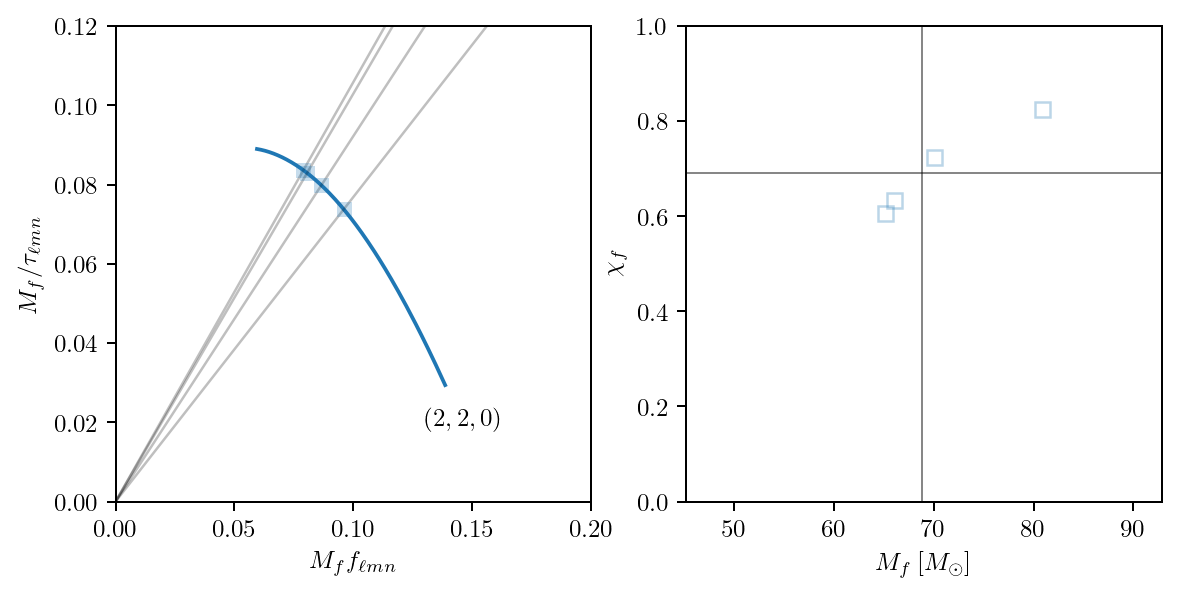

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(7.5,4), dpi=180)

axs[0].set_box_aspect(1)
axs[1].set_box_aspect(1)

chi_array = np.linspace(0, 0.99, 200)
cmap = cm.batlow

j = 0

for n in range(1):
    for l in range(2,3):
        for m in range(-l,l+1):
            
            if l == m:

                # Evaluate the QNM frequencies
                frequencies = qnm.omega(l, m, n, 1, chi_array)

                # Add to the figure
                axs[0].plot(
                    np.real(frequencies)/(2*np.pi), 
                    -np.imag(frequencies), 
                    c=f'C{j}'
                )
            
                j += 1

axs[0].set_xlabel('$M_ff_{\ell m n}$')
axs[0].set_ylabel('$M_f/ \\tau_{\ell m n}$')

axs[1].set_xlabel('$M_f\,[M_\odot]$')
axs[1].set_ylabel('$\chi_f$')

axs[0].set_xlim(0)
axs[0].set_ylim(0)

axs[1].set_ylim(0,1)

for i, (l, m, n) in enumerate(modes):
    
    omega_star = qnm.omega(l, m, n, 1, chif_star, M_sun*Mf_star*conversion)
    f_star = np.real(omega_star)/(2*np.pi)
    tau_star = -1/np.imag(omega_star)
    
    for val in fixed_vals[:4]:

        # The quality factor
        Q_star = np.pi*val[0]*val[1]

        # Add the line corresponding to the measurement
        x = np.linspace(0, 1)
        axs[0].plot(x, (np.pi/Q_star)*x, c='k', alpha=[0.25, 0.025][0], lw=1)

        # Identify points of intersection between the measurement and the Kerr 
        # spectrum

        intersected_modes = []
        fitted_spins = []
        fitted_masses = []

        j = 0

        for n in range(1):
            for l in range(2,3):
                for m in range(-l,l+1):

                    if l == m:
                        result = minimize(
                            fun, 
                            x0=0.5, 
                            args=(Q_star, l, m, n), 
                            bounds=[(0.,0.99)]
                        )
                        if result['fun']<1e-5:

                            chi_fit = result['x'][0]
                            omega_fit = qnm.omega(l, m, n, 1, chi_fit)

                            Mf_fit = (np.real(omega_fit)/(2*np.pi))/(val[0]*conversion)

                            intersected_modes.append((l,m,n))
                            fitted_spins.append(chi_fit)
                            fitted_masses.append(Mf_fit)

                            axs[0].plot(
                                np.real(omega_fit)/(2*np.pi), 
                                -np.imag(omega_fit), 
                                markers_l[i], 
                                # c=cmap(j/6),
                                c=f'C{j}',
                                markeredgewidth=0,
                                alpha=0.25
                            )

                            axs[1].plot(
                                Mf_fit/M_sun,
                                chi_fit,
                                markers_r[i],
                                ms=markersizes[i],
                                # c=cmap(j/6),
                                c=f'C{j}',
                                fillstyle='none',
                                zorder=10-j,
                                alpha=0.3
                            )

                        j += 1

        # print('Measurement compatible with modes:')
        # for mode, chi, Mf in zip(intersected_modes, fitted_spins, fitted_masses):
        #     print(f'{mode}, chi = {chi:.3f}, Mf = {Mf/M_sun:.3f} solar masses')

axs[0].text(0.65, 0.16, '$(2,2,0)$', transform=axs[0].transAxes)        
        
axs[1].axhline(chif_star, c='k', alpha=0.5, zorder=-10, lw=0.75)
axs[1].axvline(Mf_star, c='k', alpha=0.5, zorder=-10, lw=0.75)

axs[0].set_xlim(0,0.2)
axs[0].set_ylim(0,0.12)

axs[1].set_xlim((45.17236389279307, 92.85196015171452))

fig.savefig('out/4_alt.png', bbox_inches='tight', dpi=360)